In [28]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [29]:
import numpy as np
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from scipy.signal import chirp, find_peaks, peak_widths
# from scipy.signal import windows
from astropy.cosmology import FlatLambdaCDM

# import astropy.constants as const
# import astropy.units as u

In [30]:
import sys
sys.path.append("/home/minjioh/SDC3/MainDataset")
from tools import RA_DEC_fq 
from tools import pk_2D_to_1D 
from tools import pk_2D_to_2D 
from tools import pk_3D_to_2D 
from tools import DensityFlux_to_Temp 
from tools import padding

In [31]:
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import FastICA

# Contents
1. densityflux to brightness temperature
2. cut to 3x3 deg^2
3. smoothing
4. Beam correction
5. ICA for PSF residual

In [32]:
dir_path = "/home/minjioh/SDC3/Ancillary/"

filename = dir_path+'bins_kper.txt'
kper = np.loadtxt(filename)

filename = dir_path+'bins_kpar.txt'
kpar = np.loadtxt(filename)

filename = dir_path+'TestDatasetTRUTH_166MHz-181MHz.data'
Truth = np.loadtxt(filename)

In [33]:
weights= ['msw', 'msn']
data=['psf', 'image']

In [34]:
weight = weights[1]
datum=data[1]

dir_path = "/home/dhlee/SDC3/TestData/"
filename = dir_path+'TestDataset.{}_{}.fits'.format(weight,datum)
print("Reading... ", filename)
fx = fits.open(filename)
print(fx.info())

Reading...  /home/dhlee/SDC3/TestData/TestDataset.msn_image.fits
Filename: /home/dhlee/SDC3/TestData/TestDataset.msn_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   (2048, 2048, 151)   float32   
None


In [35]:
RA, DEC, fq = RA_DEC_fq(fx)

RA range      : -4.55 to 4.55
DEC range     : -34.55 to -25.45
redshift range: 6.85 to 7.55


# 1. densityflux to brightness temperature

In [36]:
cart_map_cut = DensityFlux_to_Temp(fx)
del fx

This is new


# 2. cut image to 3x3 deg^2

In [38]:
TEST = abs(RA)< 1.5 # deg
RA_min = np.where(TEST==True)[0][0]
RA_max = np.where(TEST==True)[0][-1]+1

Image_3x3 = cart_map_cut[:,RA_min:RA_max,RA_min:RA_max]
RA_3x3 = RA[RA_min:RA_max]
DEC_3x3 = DEC[RA_min:RA_max]

print(Image_3x3.shape)
print(RA_3x3.shape)
print(DEC_3x3.shape)
print(fq.shape)

del cart_map_cut
del RA
del DEC

(151, 675, 675)
(675,)
(675,)
(151,)


In [39]:
RA_3x3[337] # 0~ 674, centered well

0.0

data shape to be plotted:  (675, 675)
min/max of the pixel values:  -0.055235994160262925 0.05259084513603597
mean= 6.52615374182273e-05
std= 0.011902456277064113
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -0.05905492289535723 0.04952012327379458
mean= 0.00011769131988735622
std= 0.01219123160044379
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -0.055963882839001736 0.05214682280626958
mean= -0.00022774907588512627
std= 0.012142232054133537
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -0.05566568777250502 0.04969260224150736
mean= -0.000227738835724976
std= 0.012207072385063952
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -0.05347204862664586 0.05106262072619934
mean= 0.0002477114251564295
std= 0.012531982324490504
data shape to be plotted:  (675, 675)
min/max of the pixel values:  -0.05590599998088208 0.05075367222444746
mean= -0.0009736470496587064
std= 0.012491102692437134


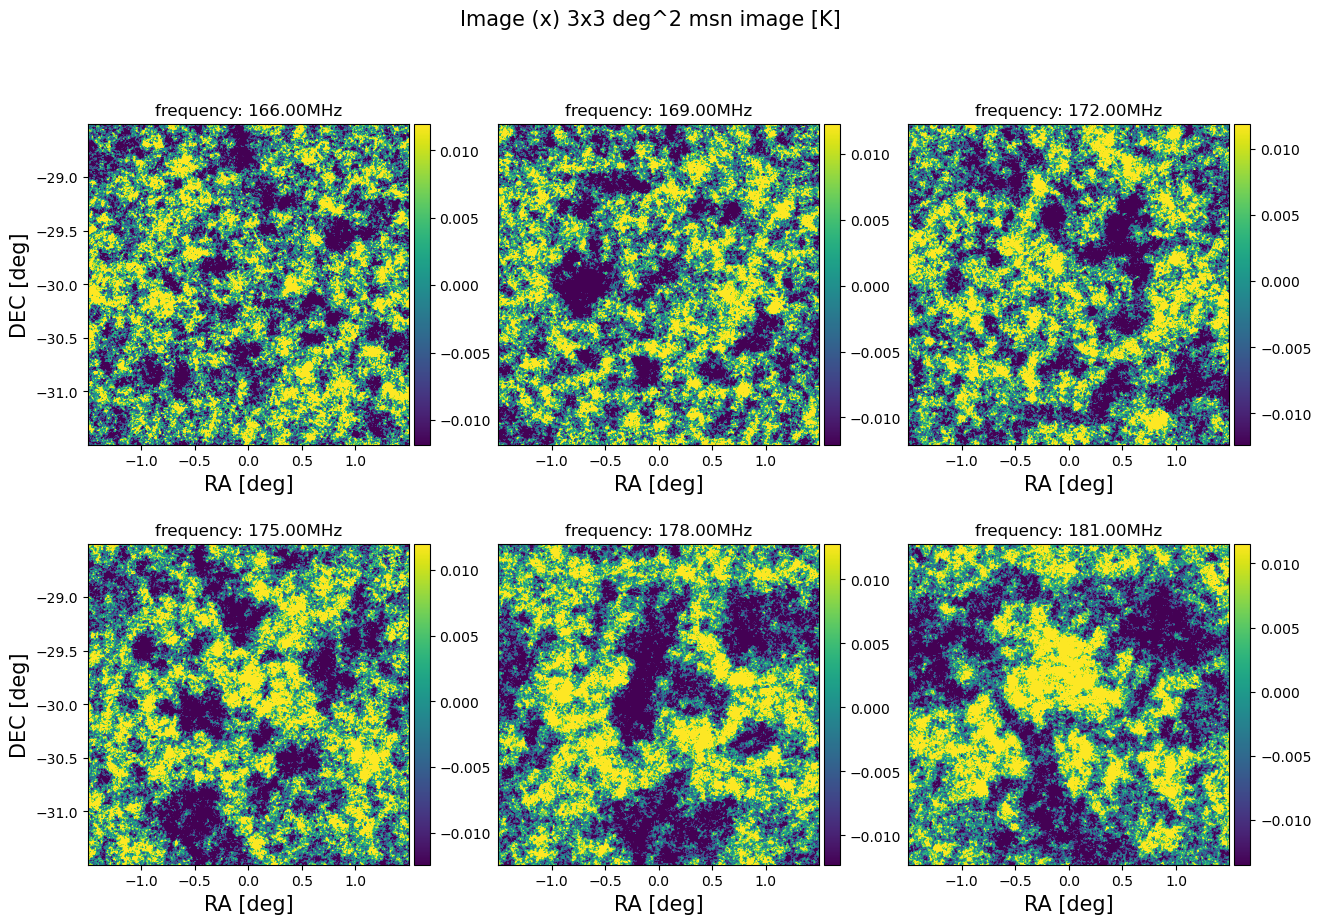

In [40]:
sample=np.array([0, 30, 60, 90, 120, 150])

plt.figure(figsize=(15,10))
ithf=0
plt.suptitle("Image (x) 3x3 deg^2 {} {} [K]".format(weight,datum),fontsize=15)
for ithf in range(6):
    plt.subplot(2,3,1+ithf)
    plt.title("frequency: {:.2f}MHz".format(fq[sample][ithf]))

    ax = plt.gca()
    myMatrix =Image_3x3[sample][ithf]

    print("data shape to be plotted: ", myMatrix.shape)
    print("min/max of the pixel values: ",np.min(myMatrix), np.max(myMatrix))

    vmin=np.std(myMatrix)
    vmean=np.mean(myMatrix)
    print("mean=", vmean)
    print("std=", vmin)
    im = plt.imshow(myMatrix,extent=([min(RA_3x3), max(RA_3x3), min(DEC_3x3), max(DEC_3x3)]),vmin=vmean-vmin,vmax=vmean+vmin)
    plt.xlabel("RA [deg]",fontsize=15)
    if ithf==0 or ithf==3:
        plt.ylabel("DEC [deg]",fontsize=15)
    else:
        plt.yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im,cax=cax)

In [42]:
# FT
ft = np.fft.fftn(Image_3x3.astype('float64'))
Tk = np.fft.fftshift(ft)
del ft

# Pk
pk2_Image_3x3, nk2_Image_3x3 = pk_3D_to_2D(kper,Tk,RA_3x3,fq)

(10,)
(151, 675, 675)
(675,)
(151,)
   314.50274013780376  Mpc
   162.43130285133157  Mpc


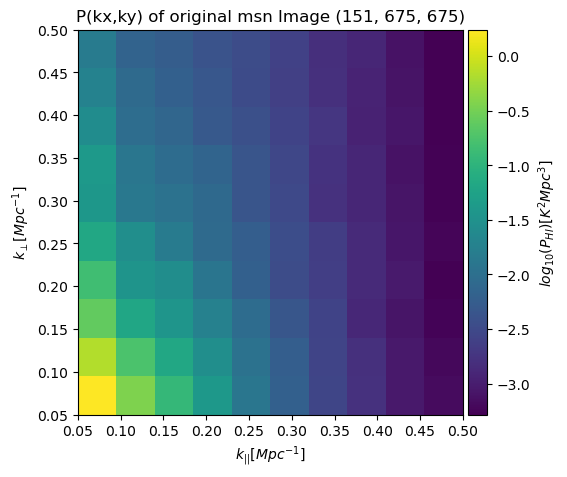

In [43]:
plt.figure(figsize=(15,5))

plt.title("P(kx,ky) of original {} Image {}".format(weight,Image_3x3.shape))
ax = plt.gca()
myMatrix =np.log10(pk2_Image_3x3)
im = plt.imshow(np.flip(myMatrix,0),extent=([min(kper), max(kper), min(kpar), max(kpar)]))
plt.ylabel(r"$k_{\perp} [Mpc^{-1}]$",fontsize=10)
plt.xlabel(r"$k_{||} [Mpc^{-1}]$",fontsize=10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im,cax=cax)
cbar.set_label(r"$log_{10}(P_{HI}) [K^{2}Mpc^{3}]$",fontsize=10)

In [44]:
del Tk

In [45]:
total_pixels = Image_3x3.shape[1]*Image_3x3.shape[2]
flattened_data = np.reshape(Image_3x3,(151,total_pixels))

/home/minjioh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/home/minjioh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guida

Text(0, 0.5, '[K]')

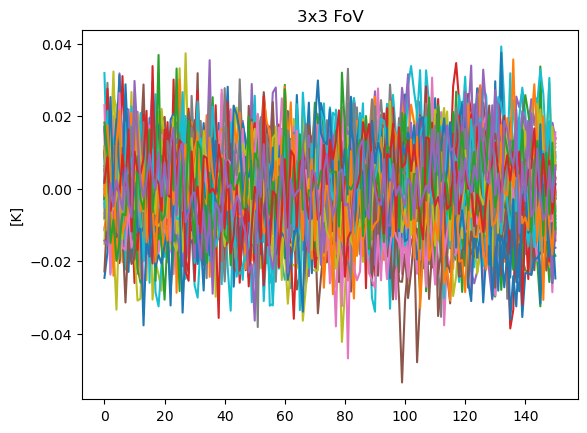

In [46]:
num_sub_samples = np.int(np.floor(np.float(total_pixels)/10000.0))
plt.title("3x3 FoV")
for i in range(0,num_sub_samples):
    plt.plot(flattened_data[:,i*10000])
plt.ylabel("[K]")

# 3. smoothing

In [54]:
sigma0 = 3.0

sigma_filter = np.zeros(Image_3x3.shape[0])

for i in range(Image_3x3.shape[0]):
    sigma_filter[i] = sigma0*(fq[-1]/fq[i])

In [55]:
Image_3x3_smooth = np.zeros(Image_3x3.shape)
for i in range(Image_3x3.shape[0]):
    Image_3x3_smooth[i] = gaussian_filter(Image_3x3[i], sigma=sigma_filter[i])

In [73]:
# FT
ft = np.fft.fftn(Image_3x3_smooth.astype('float64'))
Tk = np.fft.fftshift(ft)
del ft

pk2_Image_3x3_smooth, nk2_Image_3x3_smooth = pk_3D_to_2D(kper,Tk,RA_3x3,fq)

(10,)
(151, 675, 675)
(675,)
(151,)
   314.50274013780376  Mpc
   162.43130285133157  Mpc


# 4. Beam correction

In [56]:
dir_path = '/home/dhlee/SDC3/TestData/'
filename = dir_path+'station_beam.fits'

print("Reading... ", filename)
fx_beam = fits.open(filename)
print(fx_beam.info())

Reading...  /home/dhlee/SDC3/TestData/station_beam.fits
Filename: /home/dhlee/SDC3/TestData/station_beam.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   (2560, 2560, 901)   float32   
None


In [57]:
RA1, DEC1, fq1 = RA_DEC_fq(fx_beam)

RA range      : -5.69 to 5.68
DEC range     : -35.68 to -24.31
redshift range: 6.24 to 12.40


In [58]:
TEST = abs(RA1)< 1.5 # deg
RA_min = np.where(TEST==True)[0][0]
RA_max = np.where(TEST==True)[0][-1]+1

beam_3x3 = fx_beam['PRIMARY'].data[600:600+151,RA_min:RA_max,RA_min:RA_max]
RA1_3x3 = RA1[RA_min:RA_max]
DEC1_3x3 = DEC1[RA_min:RA_max]

print(beam_3x3.shape)
print(RA1_3x3.shape)
print(DEC1_3x3.shape)
print(fq1[600:600+151].shape)

del fx_beam
del RA1
del DEC1

(151, 675, 675)
(675,)
(675,)
(151,)


In [59]:
RA1_3x3[337] # 0~ 674

0.0

In [75]:
Tx = Image_3x3_smooth/beam_3x3

In [76]:
# FT
ft = np.fft.fftn(Tx.astype('float64'))
Tk = np.fft.fftshift(ft)
del ft

pk2_Tx, nk2_Tx = pk_3D_to_2D(kper,Tk,RA_3x3,fq)

(10,)
(151, 675, 675)
(675,)
(151,)
   314.50274013780376  Mpc
   162.43130285133157  Mpc


# 5. ICA for PSF correction

In [61]:
total_pixels = Tx.shape[1]*Tx.shape[2]
flattened_data = np.reshape(Tx,(151,total_pixels))

In [62]:
n_components = 1
ica = FastICA(n_components=n_components)
S_ = ica.fit_transform(flattened_data.T)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

In [63]:
print(flattened_data.shape,A_.shape,S_.shape,ica.mean_.shape)

(151, 455625) (151, 1) (455625, 1) (151,)


In [64]:
num_freq_bins = Tx.shape[0]

In [65]:
ica_map = np.dot(S_, A_.T) + ica.mean_

diff_map = np.zeros([num_freq_bins,total_pixels])
for i_freq in range(0,num_freq_bins):
    diff_map[i_freq,:] = flattened_data[i_freq,:] - ica_map[:,i_freq]
    
diff_map_ra_dec = np.reshape(diff_map,(Tx.shape[0],Tx.shape[1],Tx.shape[2]))

In [66]:
# FT
ft = np.fft.fftn(diff_map_ra_dec.astype('float64'))
Tk = np.fft.fftshift(ft)
del ft

In [68]:
pk2, nk2 = pk_3D_to_2D(kper,Tk,RA_3x3,fq)

(10,)
(151, 675, 675)
(675,)
(151,)
   314.50274013780376  Mpc
   162.43130285133157  Mpc


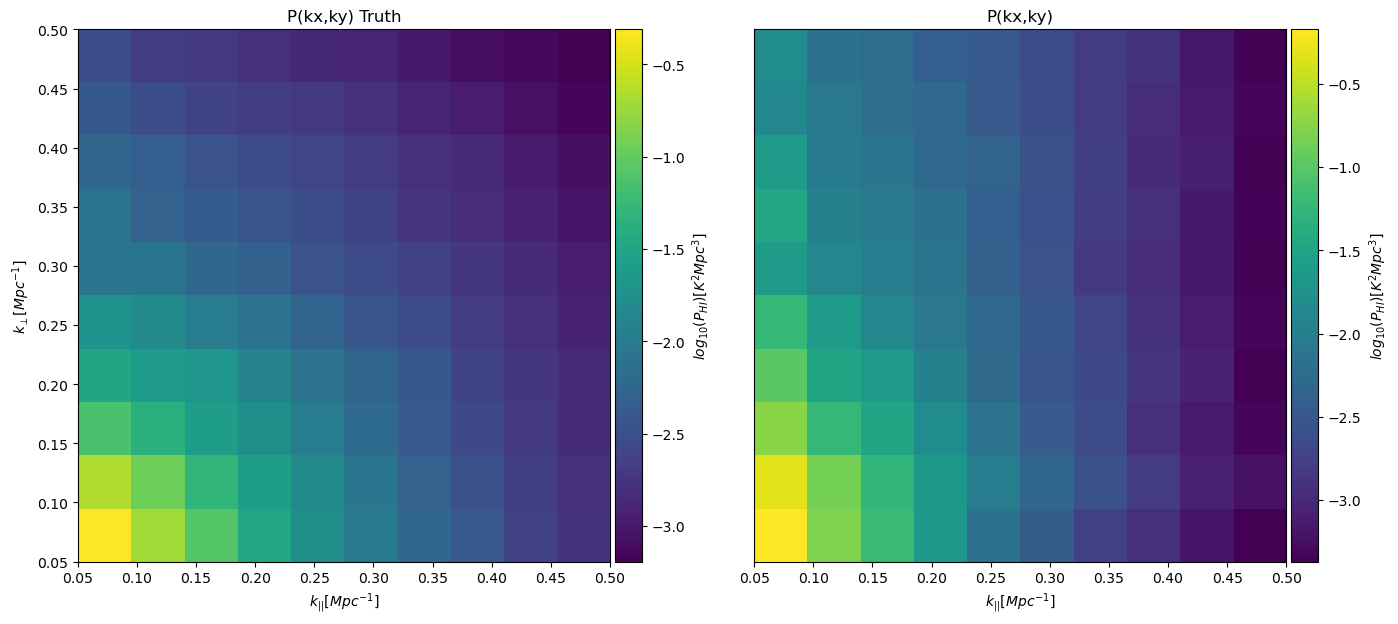

In [78]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.title("P(kx,ky) Truth".format(weight))
ax = plt.gca()
myMatrix =np.log10(Truth)
im = plt.imshow(np.flip(myMatrix,0),extent=([min(kper), max(kper), min(kpar), max(kpar)]))
plt.ylabel(r"$k_{\perp} [Mpc^{-1}]$",fontsize=10)
plt.xlabel(r"$k_{||} [Mpc^{-1}]$",fontsize=10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im,cax=cax)
cbar.set_label(r"$log_{10}(P_{HI}) [K^{2}Mpc^{3}]$",fontsize=10)

plt.subplot(1,2,2)
plt.title("P(kx,ky)".format(weight))
ax = plt.gca()
myMatrix =np.log10(pk2/3) # THIS ADDITIONAL FACTOR plays a role of normalization for PSF for the main dataset.
im = plt.imshow(np.flip(myMatrix,0),extent=([min(kper), max(kper), min(kpar), max(kpar)]))
plt.yticks([])
plt.xlabel(r"$k_{||} [Mpc^{-1}]$",fontsize=10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im,cax=cax)
cbar.set_label(r"$log_{10}(P_{HI}) [K^{2}Mpc^{3}]$",fontsize=10)

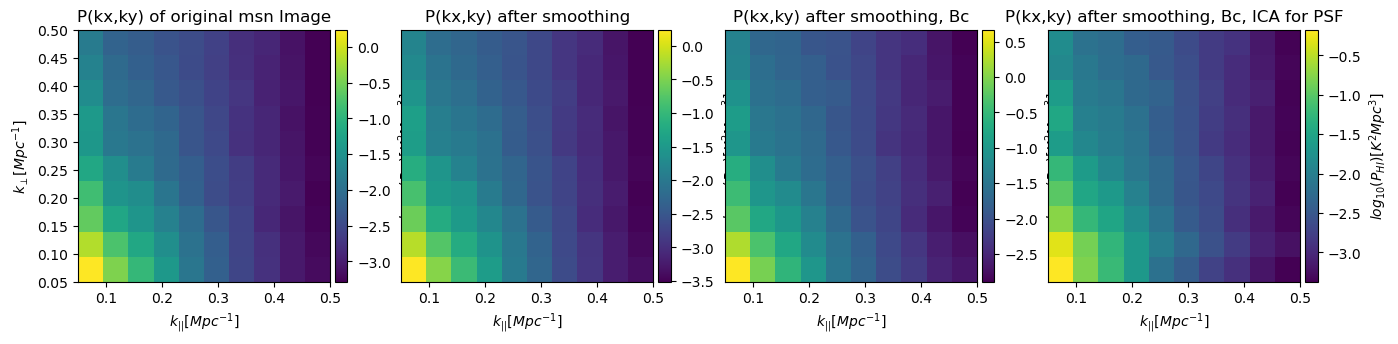

In [77]:
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.title("P(kx,ky) of original {} Image".format(weight))
ax = plt.gca()
myMatrix =np.log10(pk2_Image_3x3)
im = plt.imshow(np.flip(myMatrix,0),extent=([min(kper), max(kper), min(kpar), max(kpar)]))
plt.ylabel(r"$k_{\perp} [Mpc^{-1}]$",fontsize=10)
plt.xlabel(r"$k_{||} [Mpc^{-1}]$",fontsize=10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im,cax=cax)
cbar.set_label(r"$log_{10}(P_{HI}) [K^{2}Mpc^{3}]$",fontsize=10)

plt.subplot(1,4,2)
plt.title("P(kx,ky) after smoothing".format(weight))
ax = plt.gca()
myMatrix =np.log10(pk2_Image_3x3_smooth)
im = plt.imshow(np.flip(myMatrix,0),extent=([min(kper), max(kper), min(kpar), max(kpar)]))
# plt.ylabel(r"$k_{\perp} [Mpc^{-1}]$",fontsize=10)
plt.yticks([])
plt.xlabel(r"$k_{||} [Mpc^{-1}]$",fontsize=10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im,cax=cax)
cbar.set_label(r"$log_{10}(P_{HI}) [K^{2}Mpc^{3}]$",fontsize=10)

plt.subplot(1,4,3)
plt.title("P(kx,ky) after smoothing, Bc".format(weight))
ax = plt.gca()
myMatrix =np.log10(pk2_Tx)
im = plt.imshow(np.flip(myMatrix,0),extent=([min(kper), max(kper), min(kpar), max(kpar)]))
# plt.ylabel(r"$k_{\perp} [Mpc^{-1}]$",fontsize=10)
plt.yticks([])
plt.xlabel(r"$k_{||} [Mpc^{-1}]$",fontsize=10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im,cax=cax)
cbar.set_label(r"$log_{10}(P_{HI}) [K^{2}Mpc^{3}]$",fontsize=10)

plt.subplot(1,4,4)
plt.title("P(kx,ky) after smoothing, Bc, ICA for PSF".format(weight))
ax = plt.gca()
myMatrix =np.log10(pk2/3.)
im = plt.imshow(np.flip(myMatrix,0),extent=([min(kper), max(kper), min(kpar), max(kpar)]))
# plt.ylabel(r"$k_{\perp} [Mpc^{-1}]$",fontsize=10)
plt.yticks([])
plt.xlabel(r"$k_{||} [Mpc^{-1}]$",fontsize=10)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im,cax=cax)
cbar.set_label(r"$log_{10}(P_{HI}) [K^{2}Mpc^{3}]$",fontsize=10)